In [12]:
%matplotlib inline
#%cd ../fields_recognition/
import sys
sys.path.append("../../../")

import matplotlib.pyplot as plt
import cv2
import os
import sys
from utils.postprocessing import extract_field_images
from utils.draw_bounding_boxes import draw_bounding_box

import numpy as np
from detector import FieldDetector

In [14]:
FIELD_MODEL_PATH = '../fields_recognition/field_detector_v2.pt'

field_detector = FieldDetector(FIELD_MODEL_PATH, verbose=True)
field_detector.device_info()

Model summary: 209 layers, 43,636,779 parameters, 0 gradients, 165.4 GFLOPs
Is GPU available?: False
GPU count: 0


In [3]:
# metrics = field_detector.evaluate('./data.yaml')
# print(f'\nPrecision: {metrics['mean_precision']}')
# print(f'Recall: {metrics['mean_recall']}')
# print(f'mAP50: {metrics['mean_mAP50']}')
# print(f'mAP50-95: {metrics['mean_mAP50-95']}')

<h3>Load hình ảnh</h3>

In [17]:
import math
import random

def display_imgs(list_img, ncols = 2):
    nrows = math.ceil(len(list_img) / ncols)
    plt.figure(figsize=(10 * ncols, 5 * nrows))

    for i, img in enumerate(list_img):
        plt.subplot(nrows, ncols, i + 1)
        plt.imshow(img[:,:,::-1])
        plt.axis('off')
        plt.title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()

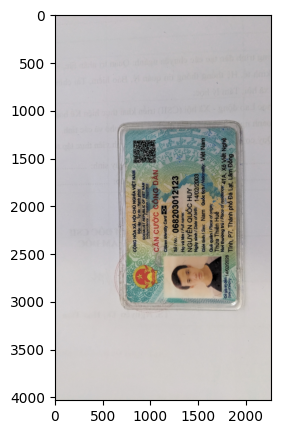

In [30]:
img = cv2.imread('../fields_recognition//PXL_20241202_143714859.jpg')
plt.figure(figsize=(10, 5))
plt.imshow(img[:,:,::-1]) 
plt.show()

<h1>Tiền xử lí dữ liệu</h1>
<ol>
    <li>Sử dụng model YoloV8 để phát hiện các góc của căn cước công dân</li>
    <li>Từ kết quả phát hiện ở trên, thực hiện xoay căn cước với kỹ thuật <strong>getPerspectiveTransform()</strong> và <strong>warpPerspective()</strong> của thư viện opencv</li>
</ol>

In [31]:

%cd ../corner_detector
sys.path.append(os.path.abspath("../corner_detector/utils"))

from corner_detector import CornerDetector

from utils.centre_point_box import get_centre_point_boxex, draw_centre_points
from utils.preprocessing import warp_image_with_centres
from utils.draw_bounding_boxes_corner import draw_bounding_box_corner

corner_detector = CornerDetector('../../models/corner_detector_v2.1.pt')
corner_detector.device_info()

c:\Users\UUN6HC\Desktop\CV_Project\src\modules\corner_detector
Is GPU available?: False
GPU count: 0


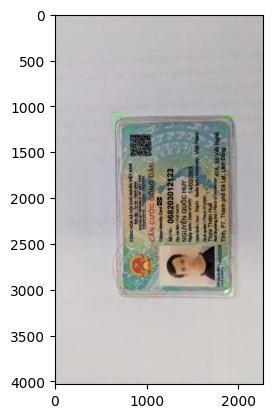

In [ ]:
from ultralytics.utils.ops import non_max_suppression
import torch


corner_result = corner_detector.predict(img)

img_drawed = draw_bounding_box_corner(corner_result[0], img.copy(), field_detector)
#img_drawed = cv2.imread(os.path.join(results[0].save_dir, './test2.jpg'))

# 3. Extract tensors from detection result
boxes_tensor = corner_result[0].boxes.xyxy  # (N, 4)
scores_tensor = corner_result[0].boxes.conf  # (N,)
class_ids = corner_result[0].boxes.cls  # (N,)

        # 4. Combine to a single tensor for NMS: (x1, y1, x2, y2, conf, class_id)
detections = torch.cat([
    boxes_tensor,
    scores_tensor.unsqueeze(1),
    class_ids.unsqueeze(1)
], dim=1)

        # 5. Apply Non-Max Suppression (YOLOv5-style)
nms_result = non_max_suppression(
    detections.unsqueeze(0),
    conf_thres=0.8,
    iou_thres=0.8
)[0]  # Take first image result


centre_points = get_centre_point_boxex(nms_result)
drawed_cp_img = draw_centre_points(img_drawed.copy(), centre_points)

# plt.figure(figsize=(200, 100))
# plt.subplot(1, 3, 1)
# plt.imshow(img[:,:,::-1]) 

# plt.subplot(1, 3, 2)
# plt.imshow(img_drawed[:,:,::-1]) 

# plt.subplot(1, 3, 3)
plt.imshow(drawed_cp_img) 
plt.show()

<h4>Kết quả tiền xử lí dữ liệu</h4>

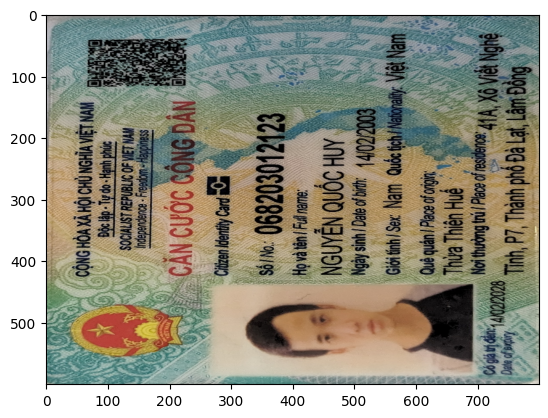

In [33]:
wrapped_img = warp_image_with_centres(img.copy(), centre_points, output_size=(800, 600))
plt.imshow(wrapped_img[:,:,::-1]) 
plt.show()

<h1>Nhận dạng các trường thông tin của căn cước</h1>

In [28]:
processed_img = wrapped_img.copy()

field_results = field_detector.predict(processed_img)
fiedl_img_drawed = draw_bounding_box(field_results[0], processed_img.copy(), field_detector)

plt.figure(figsize=(200, 100))
plt.subplot(1, 2, 1)
plt.imshow(processed_img[:,:,::-1]) 

plt.subplot(1, 2, 2)
plt.imshow(fiedl_img_drawed[:,:,::-1]) 

<h1>Xử lí kết quả</h1>

id
full_name
full_name
date_of_birth
sex
nationality
place_of_origin
place_of_residence
date_of_expiry
qr_code


<Figure size 1200x800 with 0 Axes>

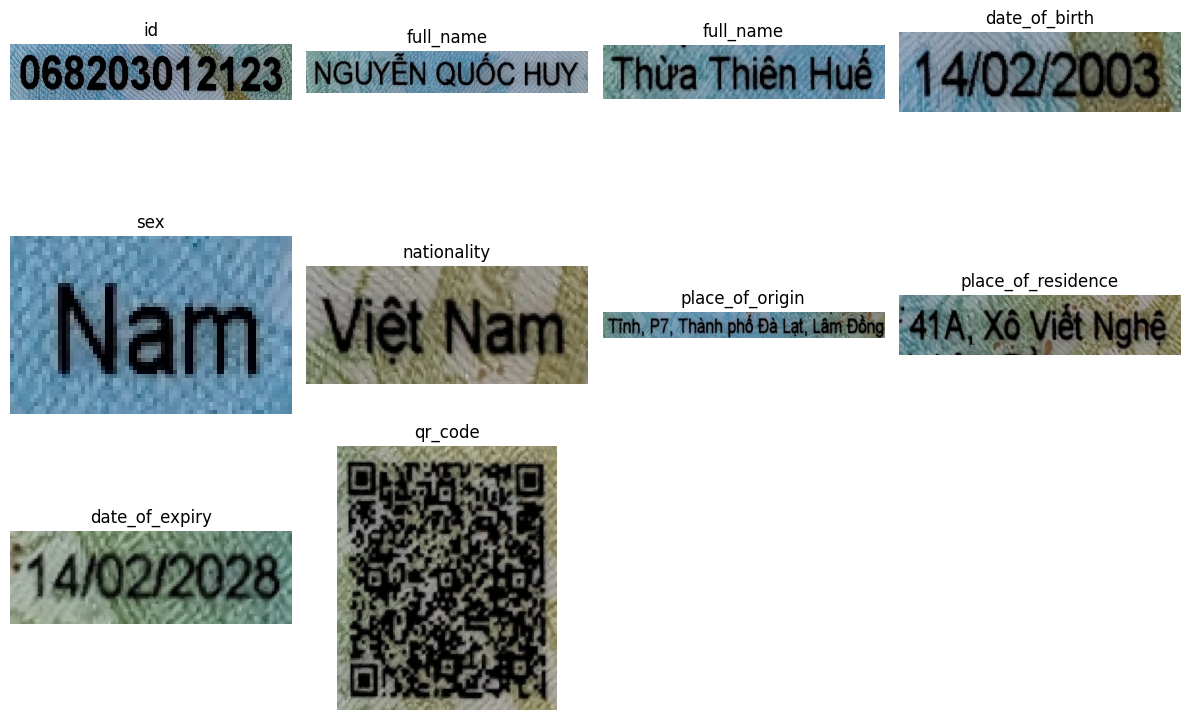

In [29]:
class_names = [
    'id', 
    'full_name', 
    'date_of_birth', 
    'sex', 
    'nationality',
    'place_of_origin',
    'place_of_residence',
    'date_of_expiry',
    'qr_code'
]

plt.figure(figsize=(12, 8))

def extract_field_images(detector, img):
    results = detector.predict(img)
    boxes = results[0].boxes.data
    boxes = sorted(boxes, key=lambda box: (box[5], box[1], box[0]))
    crops = []
    
    hit_poo = False
    
    for box in boxes:
        x1, y1, x2, y2, confidence, class_id = map(int, box[:6])
        
        
        crop = img[y1:y2, x1:x2]
        if class_id == 5 and hit_poo:
            crops.append({ "class_name": "extend_place_of_residence", "field_img": crop })
        elif class_id == 5 and not hit_poo:
            hit_poo = (class_id == 5 and not hit_poo)
            crops.append({ "class_name": "place_of_origin", "field_img": crop })
        else:
            crops.append({ "class_name": class_names[class_id], "field_img": crop })
    return crops
    
crops = extract_field_images(field_detector, wrapped_img.copy())

plt.figure(figsize=(12, 8))
for idx, crop in enumerate(crops):
    plt.subplot(3, 4, idx + 1)
    print(crop["class_name"])
    plt.imshow(crop['field_img'])
    plt.title(crop["class_name"])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [11]:
%cd ../ocr_idcard/

from idcard_translator import IdCardTranslator
translator = IdCardTranslator()
translator.read_info(crops)

f:\CV_Project\src\modules\ocr_idcard


f:\CV_Project\.venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Model weight C:\Users\admin\AppData\Local\Temp\vgg_transformer.pth exsits. Ignore download!


{'id': '068203012123',
 'full_name': 'NGUYỄN QUỐC HUY',
 'date_of_birth': '14/02/2003',
 'sex': 'Nam',
 'nationality': 'Việt Nam',
 'place_of_origin': 'Thừa Thiên Huế',
 'place_of_residence': '41A, Xô Viết Nghệ Tỉnh, P7, Thanh phố Đa Lạt, Lâm Đồng',
 'date_of_expiry': '14102/2028'}